In [39]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print ('Modules loaded')

Modules loaded


In [40]:
def print_in_color(txt_msg, fore_tupple=(0, 255, 255), back_tupple=(100, 100, 100)):
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(bb) + 'm'
    print(msg.format(mat), flush=True)
    print('\33[0m', flush=True)  # returns default print color to back to black
    return

msg = 'test color'
print_in_color(msg)

test color



In [41]:
def make_dataframes(sdir): 
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )     
    for klass in classlist:
        classpath=os.path.join(sdir, klass) 
        if os.path.isdir(classpath):
            flist=sorted(os.listdir(classpath)) 
            desc=f'{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1) 
    train_df, dummy_df=train_test_split(df, train_size=.7, shuffle=True, random_state=123, stratify=df['labels']) 
    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels']) 
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())     
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

sdir=r'E:\Automatic-Circuit-Recognition-main\trainData'
train_df, test_df, valid_df, classes, class_count=make_dataframes(sdir)
    

9                        : 100%|█████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 182320.80files/s]


number of classes in processed dataset=  19
the maximum files in any class in train_df is  138   the minimum files in any class in train_df is  70
train_df length:  2025   test_df length:  435   valid_df length:  434
average image height=  124   average image width=  142  aspect ratio h/w=  0.8732394366197183


In [42]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

In [43]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes
img_size = (224, 224)
batch_size=20
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)


Found 2025 validated image filenames belonging to 19 classes.          for train generator 
Found 434 validated image filenames belonging to 19 classes.           for valid generator 
Found 435 validated image filenames belonging to 19 classes.           for test generator 
test batch size:  29   test steps:  15  number of classes :  19


In [44]:
from keras.utils import to_categorical

# Convert 'labels' column to numeric values
train_df['labels'] = pd.to_numeric(train_df['labels'], errors='coerce')

# Correct labels exceeding the expected range [0, 14]
y_train_corrected = np.clip(train_df['labels'], 0, 14)

# Perform one-hot encoding after correcting labels
num_classes = 15  # Assuming you have 15 classes
y_train_encoded = to_categorical(y_train_corrected, num_classes=num_classes)


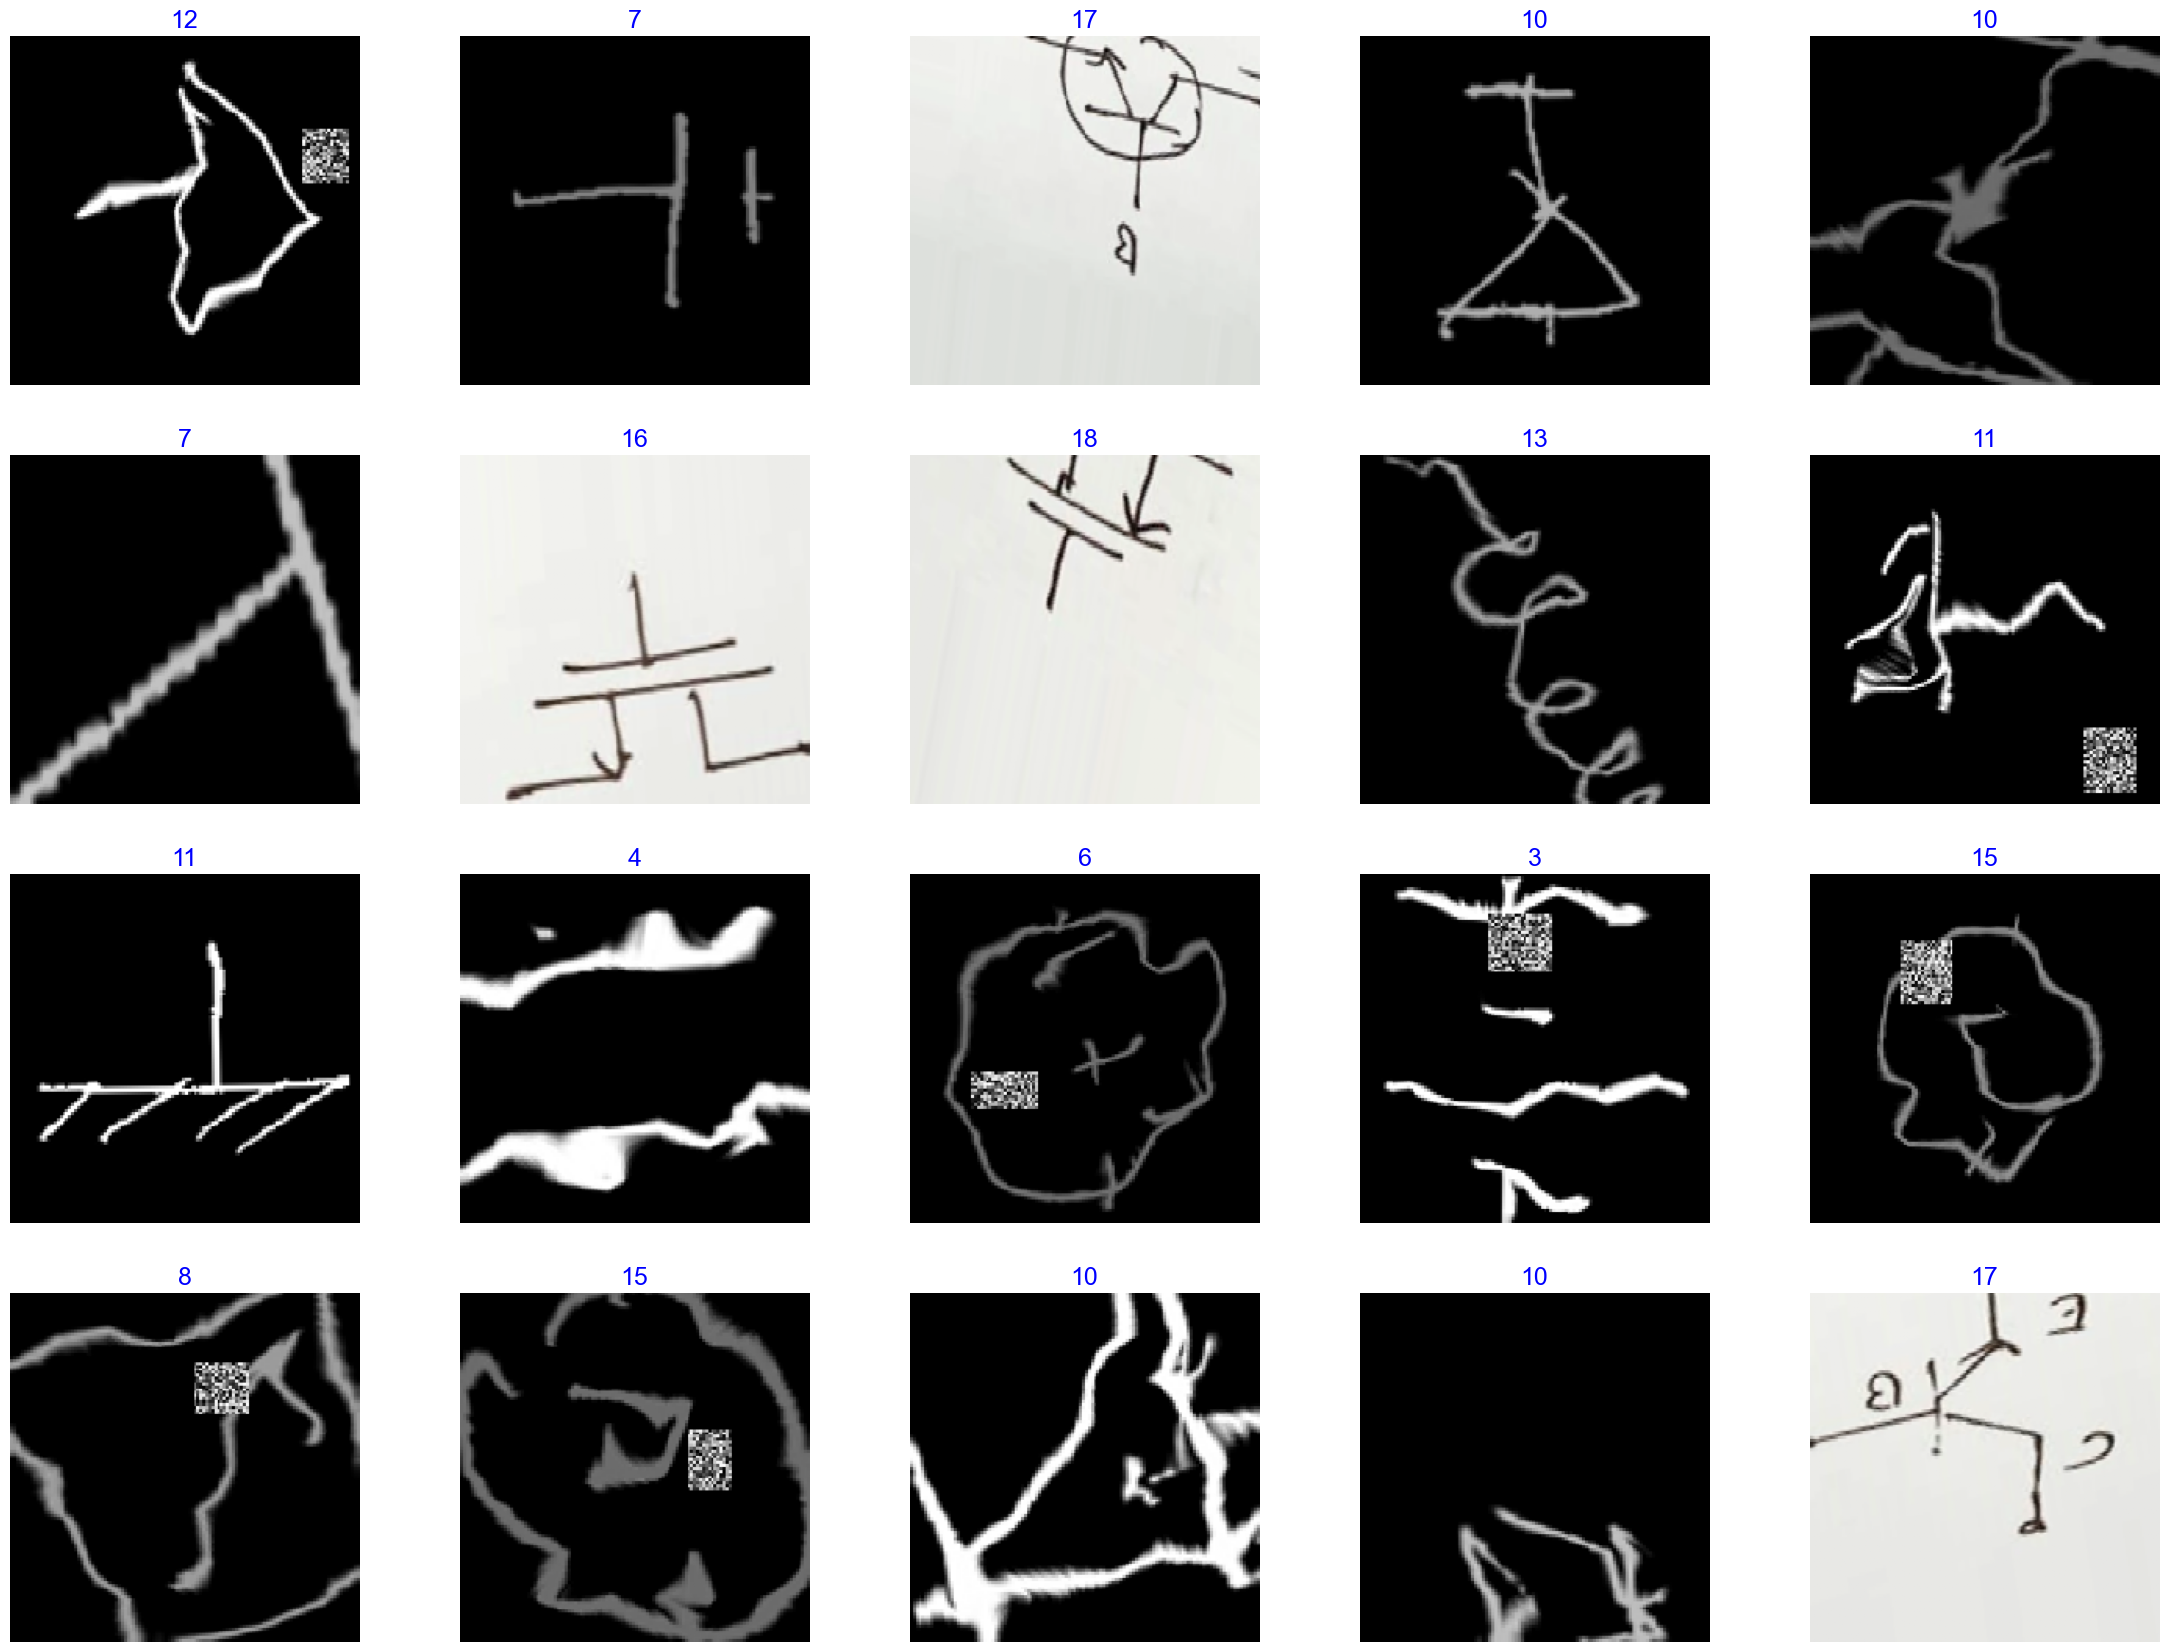

In [45]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def make_model_cnn(img_size, lr, num_classes=15):  
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')  
    ])

    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Example usage
lr = 0.001
cnn_model = make_model_cnn(img_size, lr)


In [47]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your dataset
dataset_path = "E:\\Automatic-Circuit-Recognition-main\\trainData"

# Set the image size
img_size = (32, 32)

# Create an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create separate generators for training and validation
train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Use training subset
    seed=42,
    classes=[str(i) for i in range(1, 20)]  # Include all 19 classes
)

valid_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Use validation subset
    seed=42,
    classes=[str(i) for i in range(1, 20)]  # Include all 19 classes
)

# Define your model suitable for 32x32 input images
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(19, activation='softmax')  # Adjust the number of output units to match classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 40
ask_epoch = 10
ask = LR_ASK(model, epochs, ask_epoch)
callbacks = [ask]

# Train the model with your data and one-hot encoded labels
model.fit(train_gen, epochs=40, validation_data=valid_gen)

# Use the LR_ASK callback for interactive learning rate adjustments
history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False,
    initial_epoch=0
)


Found 2319 images belonging to 19 classes.
Found 575 images belonging to 19 classes.
Epoch 1/40
73/73 [==============================] - 11s 103ms/step - loss: 2.5213 - accuracy: 0.1466 - val_loss: 2.3679 - val_accuracy: 0.1757
Epoch 2/40
73/73 [==============================] - 5s 74ms/step - loss: 2.1276 - accuracy: 0.2738 - val_loss: 2.2622 - val_accuracy: 0.1948
Epoch 3/40
73/73 [==============================] - 6s 78ms/step - loss: 1.8254 - accuracy: 0.3765 - val_loss: 2.2465 - val_accuracy: 0.2400
Epoch 4/40
73/73 [==============================] - 6s 75ms/step - loss: 1.5079 - accuracy: 0.5084 - val_loss: 2.2896 - val_accuracy: 0.2591
Epoch 5/40
73/73 [==============================] - 6s 83ms/step - loss: 1.1329 - accuracy: 0.6356 - val_loss: 2.3371 - val_accuracy: 0.2400
Epoch 6/40
73/73 [==============================] - 5s 73ms/step - loss: 0.8100 - accuracy: 0.7732 - val_loss: 2.5006 - val_accuracy: 0.2522
Epoch 7/40
73/73 [==============================] - 6s 86ms/step - 

In [65]:
# Create CNN model
import tensorflow as tf
import keras
from keras import datasets, layers, models
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,1)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(Dropout(0.50))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

#model.add(Dropout(0.50))
model.add(layers.Flatten())
model.add(layers.Dense(1024,  activation='relu'))
#model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(15, activation='softmax'))
# Compile model
#opt = keras.optimizers.Adam(learning_rate=0.0001)

print(model.summary())

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_34 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_39 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

Found 2319 images belonging to 19 classes.
Found 575 images belonging to 19 classes.
Epoch 1/40
73/73 [==============================] - 9s 88ms/step - loss: 2.4883 - accuracy: 0.1354 - val_loss: 2.3337 - val_accuracy: 0.1843
Epoch 2/40
73/73 [==============================] - 5s 70ms/step - loss: 2.1250 - accuracy: 0.2544 - val_loss: 2.2409 - val_accuracy: 0.2174
Epoch 3/40
73/73 [==============================] - 4s 57ms/step - loss: 1.7979 - accuracy: 0.3924 - val_loss: 2.1748 - val_accuracy: 0.2678
Epoch 4/40
73/73 [==============================] - 4s 50ms/step - loss: 1.4475 - accuracy: 0.5093 - val_loss: 2.2251 - val_accuracy: 0.2435
Epoch 5/40
73/73 [==============================] - 3s 46ms/step - loss: 1.1119 - accuracy: 0.6356 - val_loss: 2.3592 - val_accuracy: 0.2591
Epoch 6/40
73/73 [==============================] - 4s 49ms/step - loss: 0.8208 - accuracy: 0.7413 - val_loss: 2.5335 - val_accuracy: 0.2661
Epoch 7/40
73/73 [==============================] - 4s 56ms/step - lo

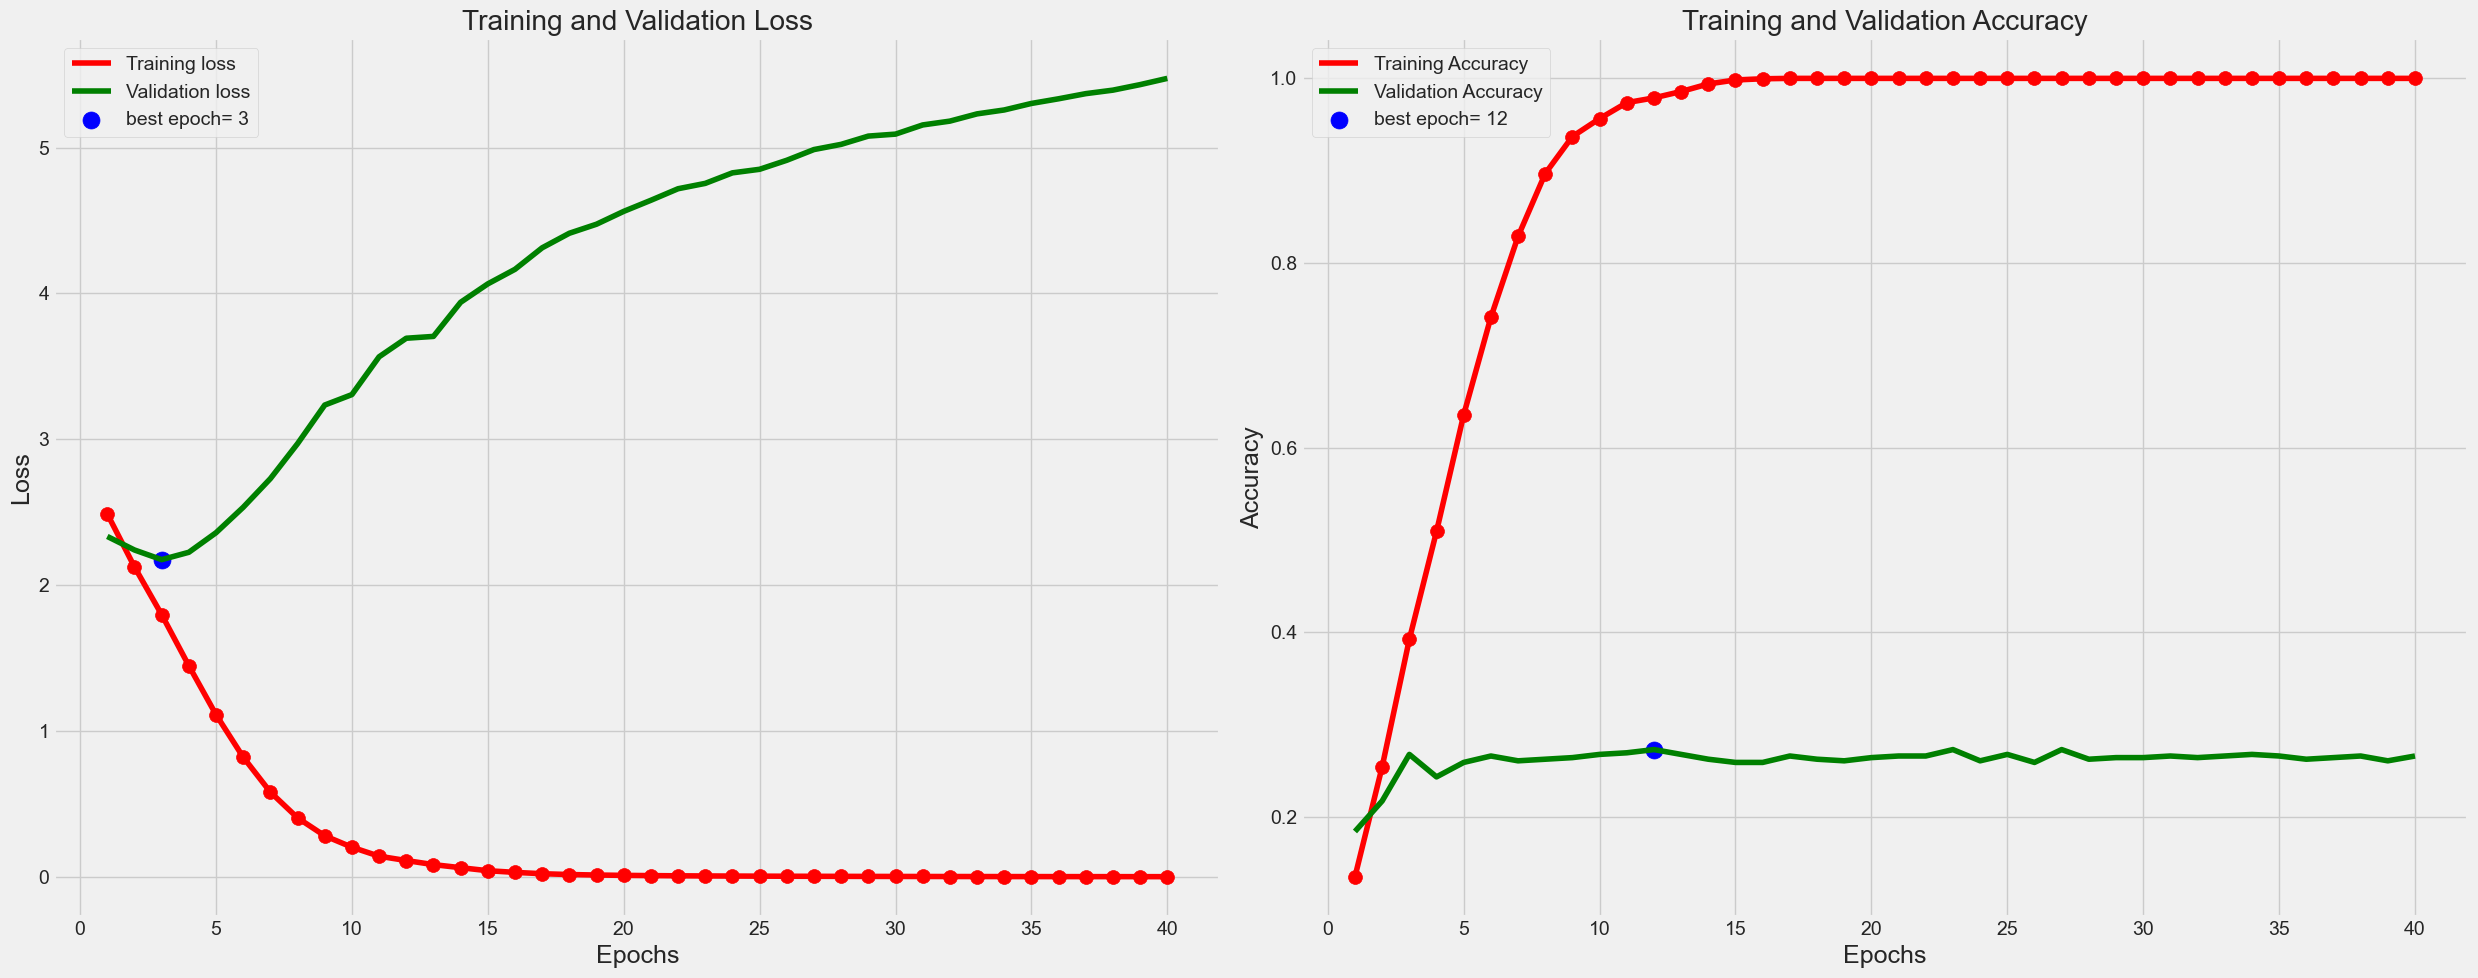

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Define the path to your dataset
dataset_path = "E:\\Automatic-Circuit-Recognition-main\\trainData"

# Set the image size
img_size = (32, 32)

# Create an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create separate generators for training and validation
train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Use training subset
    seed=42,
    classes=[str(i) for i in range(1, 20)]  # Include all 19 classes
)

valid_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Use validation subset
    seed=42,
    classes=[str(i) for i in range(1, 20)]  # Include all 19 classes
)

# Define your model suitable for 32x32 input images
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(19, activation='softmax')  # Adjust the number of output units to match classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with your data and one-hot encoded labels
epochs = 40  # Adjust as needed
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen)

def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = [i + 1 for i in range(start_epoch, Epoch_count)]
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout()
    plt.show()
    return index_loss

loss_index = tr_plot(history, 0)


Found 2894 images belonging to 19 classes.
there were 422 errors in 2894 tests for an accuracy of  85.42



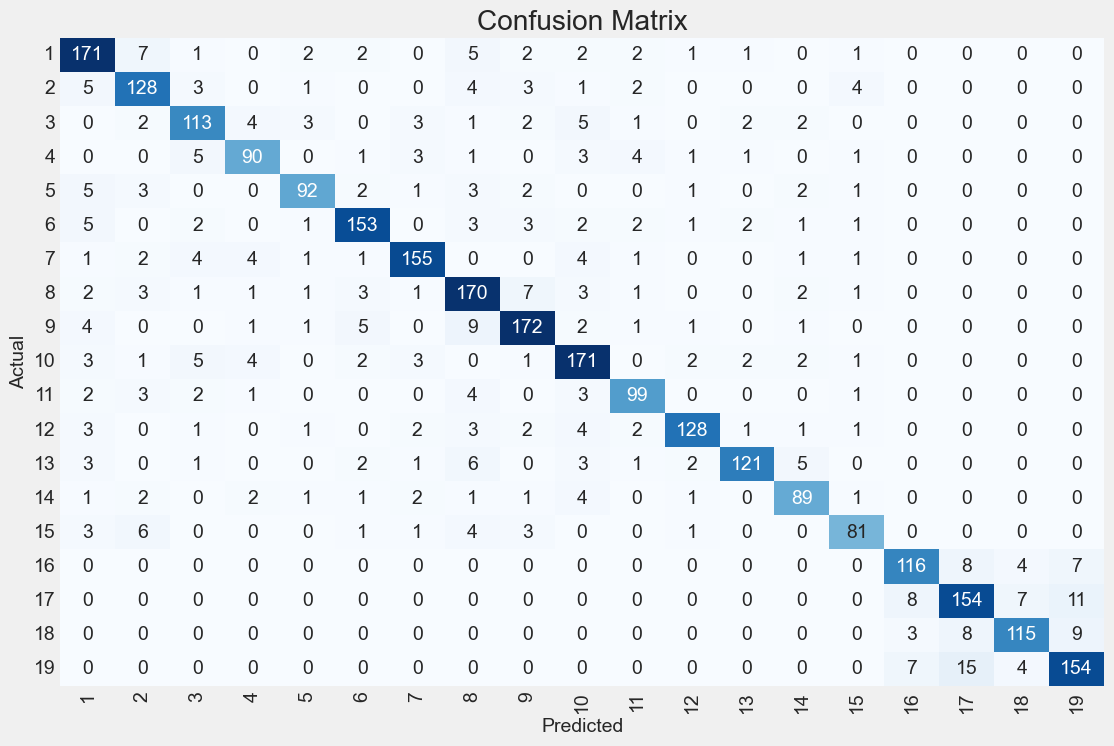

Classification Report:
----------------------
               precision    recall  f1-score   support

           1     0.8221    0.8680    0.8444       197
           2     0.8153    0.8477    0.8312       151
           3     0.8188    0.8188    0.8188       138
           4     0.8411    0.8182    0.8295       110
           5     0.8846    0.8214    0.8519       112
           6     0.8844    0.8693    0.8768       176
           7     0.9012    0.8857    0.8934       175
           8     0.7944    0.8673    0.8293       196
           9     0.8687    0.8731    0.8709       197
          10     0.8261    0.8680    0.8465       197
          11     0.8534    0.8609    0.8571       115
          12     0.9209    0.8591    0.8889       149
          13     0.9308    0.8345    0.8800       145
          14     0.8396    0.8396    0.8396       106
          15     0.8526    0.8100    0.8308       100
          16     0.8657    0.8593    0.8625       135
          17     0.8324    0.8556 

In [69]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your dataset
dataset_path = "E:\\Automatic-Circuit-Recognition-main\\trainData"

# Set the image size
img_size = (32, 32)  # Set the desired size for prediction

# Create an ImageDataGenerator for normalization
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for test data
test_gen = test_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False,  # Set shuffle to False for proper matching of predictions to filenames
    seed=42,
    classes=[str(i) for i in range(1, 20)]  # Include all 19 classes
)

def predictor(test_gen):    
    y_pred = []
    error_list = []
    error_pred_list = []
    y_true = test_gen.classes  # use .classes instead of .labels for generators
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    
    # Predict using the generator batch by batch
    preds = []
    for i in range(len(test_gen)):
        batch = test_gen[i]
        batch_preds = model.predict(batch[0], verbose=0)
        preds.extend(batch_preds)
    
    tests = len(preds)
    
    for i, p in enumerate(preds):  
        file = test_gen.filenames[i]        
        pred_index = np.argmax(p)         
        true_index = test_gen.classes[i]  # use .classes instead of .labels for generators
        
        if pred_index != true_index:  # a misclassification has occurred                                           
            errors += 1
            file = test_gen.filenames[i]            
            error_class = classes[pred_index]
            t = (file, error_class)
            error_list.append(t)            
        y_pred.append(pred_index)
            
    acc = (1 - errors/tests) * 100
    msg = f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0, 255, 255), (100, 100, 100))  # cyan foreground
    
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    
    f1score = f1_score(ytrue, ypred, average='weighted') * 100
    
    if class_count <= 30:
        cm = confusion_matrix(ytrue, ypred)
        
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)  # create classification report
    print("Classification Report:\n----------------------\n", clr)
    
    return errors, tests, error_list, f1score

# Assuming you have a test generator named test_gen
errors, tests, error_list, f1score = predictor(test_gen)


In [70]:
if len(error_list) > 0 and len(error_list) < 50:
    print('Below is a list of test files that were misclassified:\n')
    print('{0:^30s}{1:^30s}'.format('Test File', ' Predicted as'))

    sorted_list = sorted(error_list)
    
    # Print the contents of error_list for debugging
    for item in sorted_list:
        print(item)
    
    for i in range(len(sorted_list)):
        fpath = sorted_list[i][0]
        split = fpath.split('/')
        f = split[4]
        pred_class = sorted_list[i][1]
        print(f'{f:^30s}{pred_class:^30s}')


In [73]:
name = 'symbols-' + str(len(classes)) + '-(' + str(img_size[0]) + ' X ' + str(img_size[1]) + ')'
save_id = f'{name}-{f1score:5.2f}.h5'
model_save_loc = os.path.join(save_id)  # Remove 'working_dir' from the path
model.save(model_save_loc)
msg = f'model was saved as {model_save_loc}'
print_in_color(msg, (0, 255, 255), (100, 100, 100))  # cyan foreground

model was saved as symbols-19-(32 X 32)-85.45.h5



In [ ]:
# Create CNN model
import tensorflow as tf
import keras
from keras import datasets, layers, models
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,1)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(Dropout(0.50))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

#model.add(Dropout(0.50))
model.add(layers.Flatten())
model.add(layers.Dense(1024,  activation='relu'))
#model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(15, activation='softmax'))
# Compile model
#opt = keras.optimizers.Adam(learning_rate=0.0001)

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      